# Diff Graph U-Net: main result illustration

***$\spadesuit$ Manxi Lin*** &nbsp; &nbsp;***$\spadesuit$Mengge Hu*** &nbsp; &nbsp;  ***$\spadesuit$Guangya Shen***  
*s192230* &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp;*s192113* &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;*s200104*

Our implementation follows Rex Ying's pioneering work ***Hierarchical Graph Representation Learning with Differentiable Pooling***. The training was done by shell scripts (check the scripts in `./example.sh`) on a server, instead of this jupyter notebook. Two networks were implemented in our experiments, one is the baseline model and the other is what we proposed. To fetch a convincing result, 10-fold cross-validation was used. The two models were evaluated in 4 different data sets. It's clear that we have $2\times 10\times 4=80$ different trained nets. They take up much space. It's apparently not possible to upload all of them on GitHub and show them here. **Hence, we plan to run the networks from beginning.** That's why you may find ***the result in this notebook is not exactly the same with what we list in our poster and report in value.*** But our conclusion stays the same, that is, **the proposed model has a better performance than the baseline model.**

Plus, we made screenshots for each of our models. If you are interested in the optimal models we trained, you may have a glance at the folder, `./screenshots`. 

**Note that DIFFPOOL(our baseline model) could be very unstable to train, and there is significant variation in accuracy across different runs, even with the same hyperparameter setting. So does our U-Net.**  That is a reason why we implemented 10-fold cross-validation in former training, and took the average accuracy. In this notebook, to save time and to make the layout neat, we would not apply 10-fold cross-validation. For the same reason, we changed the training hyperparameters slightly. These would not affect our conclusion (again): **the proposed model has a better performance than the baseline model.** 

In [ ]:
# NB: To run our script, you may need to install networkx
!pip install networkx

In [162]:
## import
import matplotlib.pyplot as plt

import networkx as nx

import numpy as np

import sklearn.metrics as metrics

import torch
import torch.nn as nn
from torch.autograd import Variable

torch.backends.cudnn.enabled = False

import os
import pickle
import random
import shutil

import encoders
import math
from collections import Counter

from load_data import read_graphfile# load_data is a module to transform text file to graphs
# from graph_sampler import GraphSampler

import util

#Comparision between DIFFPOOL and U-NET

In [45]:
# first, let's define a data set store sampled graphs
# -> for each graph, if the number of nodes is larger than max_num_nodes, downsampling it
# otherwise, upsampling it
class GraphSampler(torch.utils.data.Dataset):
    def __init__(self, graphs, labels, max_num_nodes):
        super(GraphSampler, self).__init__()
    
        self.labels = labels
        # node features:
        # -> for those without node features, use the node label as features
        self.add_feat = True
        if 'feat' not in graphs[0].nodes[0].keys():
            self.add_feat = False
        self.graphs = graphs
        self.assign_feats = np.identity(max_num_nodes) # initilize assignment matrix with an identity matrix
        self.max_num_nodes = max_num_nodes
        
    @staticmethod
    def concat_feats(graph, add_feat, max_num_nodes):
        if add_feat:
            feats = list(map(lambda x: list(graph.nodes[x]['label'])+list(graph.nodes[x]['feat']), graph.nodes))
        else:
            feats = list(map(lambda x: list(graph.nodes[x]['label']), graph.nodes))
        feats = np.array(feats)
        feats_all = np.zeros((max_num_nodes, feats.shape[1]))
        if feats.shape[0] > max_num_nodes:
          # then downsample
          feas_all = feats[:max_num_nodes, :]
        else:
          # upsample
          feats_all[:feats.shape[0], :] = feats
        return feats_all
    
    @staticmethod
    def generate_adj(graph, max_num_nodes, normalize=True):
        adj = np.array(nx.to_numpy_matrix(graph))
        if normalize:
            sqrt_deg = np.diag(1.0 / np.sqrt(np.sum(adj, axis=0, dtype=float).squeeze()))
            adj = np.matmul(np.matmul(sqrt_deg, adj), sqrt_deg)
        adj_all = np.zeros((max_num_nodes, max_num_nodes))
        if adj.shape[0] > max_num_nodes:
          # then downsample
          adj_all = adj[:max_num_nodes, :max_num_nodes]
        else:
          # upsample
          adj_all[:adj.shape[0], :adj.shape[1]] = adj
        
        return adj_all
        
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, idx):
        graph = self.graphs[idx]
        feats = []
        adjs = []
        feats = self.concat_feats(graph, self.add_feat, self.max_num_nodes)
        adj = self.generate_adj(graph, self.max_num_nodes)
        return {'adj':adj.copy(),
                'feats':feats.copy(),
                'label':self.labels[idx].copy(),
                'num_nodes':min(np.array(nx.to_numpy_matrix(graph)).shape[0], self.max_num_nodes),
                'assign_feats':self.assign_feats.copy()}


In [107]:
# first, let's define a function to load data
def load_data(dataname, datadir='./data', max_num_nodes=0, test_rat=0.1):
    '''
    dataname: name of the data set
    datadir: data directory
    max_num_nodes: maximum number of nodes in a graph
    '''
    graphs = read_graphfile(datadir, dataname) # graph is a list of graphs

    labels = list(map(lambda x: x.graph['label'], graphs))

    idx = list(range(len(graphs)))
    random.shuffle(idx)

    # split train set and test set
    # the ratio is train+vali:test = 9:1
    trainv_idx = idx[int(len(idx)*test_rat):]
    test_idx = idx[:int(len(idx)*test_rat)]


    ## NB: 10-fold cross validation is SUPER time-consuming
    # instead, we implement our training in another way
    '''
    # ten-fold cross validation
    num_fold = 10
    vali_size = int(len(trainv_idx)/num_fold)
    train_idx = []
    vali_idx = []

    # first n-1 folds
    for i in range(num_fold-1):
      vali_idx.append(trainv_idx[i*vali_size:(i+1)*vali_size])
      train_idx.append(trainv_idx[:i*vali_size] + trainv_idx[(i+1)*vali_size:])

    # the last fold
    vali_idx.append(trainv_idx[9*vali_size:])
    train_idx.append(trainv_idx[:9*vali_size])
    '''
    # the ratio of train:vali = 8:1
    vali_idx = trainv_idx[:int(len(idx)*test_rat)]
    train_idx = trainv_idx[int(len(idx)*test_rat):]   
    
    return graphs, labels, train_idx, vali_idx, test_idx   

def idxToele(obj, idx):
  return list(map(lambda x: obj[x], idx))

In [46]:
# Dataset 1: ENZYMES

#-> set parameters
max_num_nodes = 225
batch_size = 20

graphs, labels, train_idx, vali_idx, test_idx = load_data('ENZYMES', max_num_nodes=max_num_nodes)
input_dim = len(graphs[0].nodes[0]['feat']) + len(graphs[0].nodes[0]['label'])

# sample graphs and create torch datasets
test_set = GraphSampler(idxToele(graphs, test_idx), idxToele(labels, test_idx), max_num_nodes)
# test_set = GraphSampler(idxToele(graphs, test_idx), max_num_nodes=max_num_nodes)
test_loader = torch.utils.data.DataLoader(
            test_set, 
            batch_size=batch_size, 
            shuffle=True)

train_set = GraphSampler(idxToele(graphs, train_idx), idxToele(labels, train_idx), max_num_nodes)
# train_set = GraphSampler(idxToele(graphs, train_idx), max_num_nodes=max_num_nodes)
train_loader = torch.utils.data.DataLoader(
            train_set, 
            batch_size=batch_size, 
            shuffle=True)

# validation set here is used to tune superparameters
vali_set = GraphSampler(idxToele(graphs, vali_idx), idxToele(labels, vali_idx), max_num_nodes)
# vali_set = GraphSampler(idxToele(graphs, vali_idx), max_num_nodes=max_num_nodes)
vali_loader = torch.utils.data.DataLoader(
            vali_set, 
            batch_size=batch_size, 
            shuffle=True)

In [47]:
# build network
# baseline

## model parameters
lr=1e-3
num_epochs=100
hidden_dim=64
output_dim=64
num_classes=6
num_gc_layers=3
dropout=0.0
assign_ratio=1/15
num_pool=2
num_unpool=0
ratio_unpool=0.1
weight_decay=0
dupli_adj = False
trans_S = True
rcs_lambda = 0
clip = 2


baseline = encoders.SoftPoolingGcnEncoder(
            max_num_nodes=max_num_nodes, 
            input_dim=input_dim, hidden_dim=hidden_dim, 
            embedding_dim=output_dim, 
            label_dim=num_classes, 
            num_layers=num_gc_layers,
            assign_hidden_dim=hidden_dim,
            assign_num_layers=num_gc_layers,
            assign_ratio=assign_ratio, 
            num_pooling=num_pool,
            assign_input_dim=max_num_nodes, 
            num_unpooling=num_unpool, 
            unpool_ratio=ratio_unpool,
            linkpred=False).cuda()



There are 2 pooling layers while 0 unpooling layers
Pooling ratio is 0.06666666666666667 while unpooling ratio is 0.1

Abandoned UNPOOLING



In [48]:
# begin training: baseline

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, baseline.parameters()), 
    lr=lr, weight_decay=weight_decay)

best_result = {'epoch': 0, 'accuracy': 0, 'loss': 0}

baseline_params = []

for epoch in range(num_epochs):
  avg_loss = 0
  baseline.train()
  print('Epoch: ', epoch)

  for batch_idx, data in enumerate(train_loader):
    baseline.zero_grad()

    adj = Variable(data['adj'].float(), requires_grad=False).cuda()
    h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
    label = Variable(data['label'].long()).cuda()
    batch_num_nodes = data['num_nodes'].int().numpy()
    assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

    ypred = baseline(h0, adj, batch_num_nodes, assign_x=assign_input, \
                  dupl_adj=dupli_adj, trans_S=trans_S)

    loss = baseline.loss(ypred, label)
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()

    avg_loss += loss
    avg_loss /= batch_idx + 1

  # evaluate every epoch
  if 0 == epoch%1:
    baseline.eval()
    label_list = []
    preds = []
    for batch_idx, data in enumerate(vali_loader):

      adj = Variable(data['adj'].float(), requires_grad=False).cuda()
      h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
      label_list.append(Variable(data['label'].long()).numpy())
      batch_num_nodes = data['num_nodes'].int().numpy()
      assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

      ypred = baseline(h0, adj, batch_num_nodes, assign_x=assign_input, \
                dupl_adj=dupli_adj, trans_S=trans_S)
        
      _, indices = torch.max(ypred, 1)
      preds.append(indices.cpu().data.numpy())

    label_list = np.hstack(label_list)
    preds = np.hstack(preds)
    
    result = {'prec': metrics.precision_score(label_list, preds, average='macro'),
          'recall': metrics.recall_score(label_list, preds, average='macro'),
          'acc': metrics.accuracy_score(label_list, preds),
          'F1': metrics.f1_score(label_list, preds, average="micro")}
    if result['acc'] > best_result['accuracy']:
      best_result['accuracy'] = round(result['acc'], 2)
      best_result['epoch'] = epoch
      best_result['loss'] = round(avg_loss.item(), 4) # note that we used train loss here
      baseline_params = baseline.state_dict()
      
    print('acc: ',round(result['acc'], 2),'loss: ',round(avg_loss.item(), 4))
    print('best result: ')
    print(best_result)

Epoch:  0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


acc:  0.22 loss:  0.0715
best result: 
{'epoch': 0, 'accuracy': 0.22, 'loss': 0.0715}
Epoch:  1
acc:  0.28 loss:  0.0696
best result: 
{'epoch': 1, 'accuracy': 0.28, 'loss': 0.0696}
Epoch:  2
acc:  0.23 loss:  0.0769
best result: 
{'epoch': 1, 'accuracy': 0.28, 'loss': 0.0696}
Epoch:  3
acc:  0.2 loss:  0.0692
best result: 
{'epoch': 1, 'accuracy': 0.28, 'loss': 0.0696}
Epoch:  4
acc:  0.13 loss:  0.0746
best result: 
{'epoch': 1, 'accuracy': 0.28, 'loss': 0.0696}
Epoch:  5
acc:  0.37 loss:  0.067
best result: 
{'epoch': 5, 'accuracy': 0.37, 'loss': 0.067}
Epoch:  6
acc:  0.2 loss:  0.0643
best result: 
{'epoch': 5, 'accuracy': 0.37, 'loss': 0.067}
Epoch:  7
acc:  0.13 loss:  0.0623
best result: 
{'epoch': 5, 'accuracy': 0.37, 'loss': 0.067}
Epoch:  8
acc:  0.23 loss:  0.0664
best result: 
{'epoch': 5, 'accuracy': 0.37, 'loss': 0.067}
Epoch:  9
acc:  0.32 loss:  0.0669
best result: 
{'epoch': 5, 'accuracy': 0.37, 'loss': 0.067}
Epoch:  10
acc:  0.33 loss:  0.0678
best result: 
{'epoch'

In [50]:
# build network
# U-Net

## model parameters
lr=1e-3
num_epochs=100
batch_size=20
hidden_dim=64
output_dim=64
num_classes=6
num_gc_layers=3
dropout=0.1
assign_ratio=1/15
num_pool=2
num_unpool=2
ratio_unpool=1/15
weight_decay = 0
dupli_adj = False
trans_S = True
rcs_lambda = 0
clip = 2

model = encoders.SoftPoolingGcnEncoder(
            max_num_nodes=max_num_nodes, 
            input_dim=input_dim, hidden_dim=hidden_dim, 
            embedding_dim=output_dim, 
            label_dim=num_classes, 
            num_layers=num_gc_layers,
            assign_hidden_dim=hidden_dim,
            assign_num_layers=num_gc_layers,
            assign_ratio=assign_ratio, 
            num_pooling=num_pool,
            assign_input_dim=max_num_nodes, 
            num_unpooling=num_unpool, 
            unpool_ratio=ratio_unpool,
            linkpred=False).cuda()

In [51]:
# begin training: U-Net

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
    lr=lr, weight_decay=weight_decay)

best_result = {'epoch': 0, 'accuracy': 0, 'loss': 0}

model_params = []

for epoch in range(num_epochs):
  avg_loss = 0
  model.train()
  print('Epoch: ', epoch)

  for batch_idx, data in enumerate(train_loader):
    model.zero_grad()

    adj = Variable(data['adj'].float(), requires_grad=False).cuda()
    h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
    label = Variable(data['label'].long()).cuda()
    batch_num_nodes = data['num_nodes'].int().numpy()
    assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

    ypred = model(h0, adj, batch_num_nodes, assign_x=assign_input, \
                  dupl_adj=dupli_adj, trans_S=trans_S)

    loss = model.loss(ypred, label)
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()

    avg_loss += loss
    avg_loss /= batch_idx + 1

  # evaluate every epoch
  if 0 == epoch%1:
    model.eval()
    label_list = []
    preds = []
    for batch_idx, data in enumerate(vali_loader):
      model.zero_grad()
      adj = Variable(data['adj'].float(), requires_grad=False).cuda()
      h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
      label_list.append(Variable(data['label'].long()).numpy())
      batch_num_nodes = data['num_nodes'].int().numpy()
      assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

      ypred = model(h0, adj, batch_num_nodes, assign_x=assign_input, \
                dupl_adj=dupli_adj, trans_S=trans_S)
        
      _, indices = torch.max(ypred, 1)
      preds.append(indices.cpu().data.numpy())

    label_list = np.hstack(label_list)
    preds = np.hstack(preds)
    
    result = {'prec': metrics.precision_score(label_list, preds, average='macro'),
          'recall': metrics.recall_score(label_list, preds, average='macro'),
          'acc': metrics.accuracy_score(label_list, preds),
          'F1': metrics.f1_score(label_list, preds, average="micro")}
    if result['acc'] > best_result['accuracy']:
      best_result['accuracy'] = round(result['acc'], 2)
      best_result['epoch'] = epoch
      best_result['loss'] = round(avg_loss.item(), 4) # note that we used train loss here
      model_params = model.state_dict()
      
    print('acc: ',round(result['acc'], 2),'loss: ',round(avg_loss.item(), 4))
    print('best result: ')
    print(best_result)

Epoch:  0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


acc:  0.22 loss:  0.0658
best result: 
{'epoch': 0, 'accuracy': 0.22, 'loss': 0.0658}
Epoch:  1
acc:  0.2 loss:  0.0624
best result: 
{'epoch': 0, 'accuracy': 0.22, 'loss': 0.0658}
Epoch:  2
acc:  0.27 loss:  0.0703
best result: 
{'epoch': 2, 'accuracy': 0.27, 'loss': 0.0703}
Epoch:  3
acc:  0.28 loss:  0.0651
best result: 
{'epoch': 3, 'accuracy': 0.28, 'loss': 0.0651}
Epoch:  4
acc:  0.25 loss:  0.0694
best result: 
{'epoch': 3, 'accuracy': 0.28, 'loss': 0.0651}
Epoch:  5
acc:  0.32 loss:  0.0719
best result: 
{'epoch': 5, 'accuracy': 0.32, 'loss': 0.0719}
Epoch:  6
acc:  0.2 loss:  0.0713
best result: 
{'epoch': 5, 'accuracy': 0.32, 'loss': 0.0719}
Epoch:  7
acc:  0.35 loss:  0.0654
best result: 
{'epoch': 7, 'accuracy': 0.35, 'loss': 0.0654}
Epoch:  8
acc:  0.25 loss:  0.0698
best result: 
{'epoch': 7, 'accuracy': 0.35, 'loss': 0.0654}
Epoch:  9
acc:  0.2 loss:  0.0687
best result: 
{'epoch': 7, 'accuracy': 0.35, 'loss': 0.0654}
Epoch:  10
acc:  0.25 loss:  0.0705
best result: 
{'e

In [52]:
# evaluate on the test set
label_list = []

preds_bl = []
preds_md = []

# load the optimal model
baseline.load_state_dict(baseline_params)
baseline.eval()

model.load_state_dict(model_params)
model.eval()

for batch_idx, data in enumerate(test_loader):
  adj = Variable(data['adj'].float(), requires_grad=False).cuda()
  h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
  label_list.append(Variable(data['label'].long()).numpy())
  batch_num_nodes = data['num_nodes'].int().numpy()
  assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

  ypred = baseline(h0, adj, batch_num_nodes, assign_x=assign_input, \
              dupl_adj=dupli_adj, trans_S=trans_S)
        
  _, indices = torch.max(ypred, 1)
  preds_bl.append(indices.cpu().data.numpy())

  ypred = model(h0, adj, batch_num_nodes, assign_x=assign_input, \
              dupl_adj=dupli_adj, trans_S=trans_S)
        
  _, indices = torch.max(ypred, 1)
  preds_md.append(indices.cpu().data.numpy())

label_list = np.hstack(label_list)
preds_bl = np.hstack(preds_bl)
preds_md = np.hstack(preds_md)
    
result_bl = {'prec': metrics.precision_score(label_list, preds_bl, average='macro'),
      'recall': metrics.recall_score(label_list, preds_bl, average='macro'),
      'acc': metrics.accuracy_score(label_list, preds_bl),
      'F1': metrics.f1_score(label_list, preds_bl, average="micro")}

result_md = {'prec': metrics.precision_score(label_list, preds_md, average='macro'),
      'recall': metrics.recall_score(label_list, preds_md, average='macro'),
      'acc': metrics.accuracy_score(label_list, preds_md),
      'F1': metrics.f1_score(label_list, preds_md, average="micro")}

print('dataset: ENZYMES')
print('test result: ')
print()

print('baseline: ')
print(result_bl)

print()

print('U-Net: ')
print(result_md)

dataset: ENZYMES
test result: 

baseline: 
{'prec': 0.3527777777777778, 'recall': 0.3177248677248677, 'acc': 0.35, 'F1': 0.35}

U-Net: 
{'prec': 0.5746031746031747, 'recall': 0.5499999999999999, 'acc': 0.5166666666666667, 'F1': 0.5166666666666667}


`Comment`: 

>You may notice that U-Net outperforms the baseline model with an overall improvement.

In [60]:
# Dataset 2: D&D

#-> set parameters
max_num_nodes = 1000
batch_size = 20

graphs, labels, train_idx, vali_idx, test_idx = load_data('DD', max_num_nodes=max_num_nodes)
input_dim = len(graphs[0].nodes[0]['label'])

# sample graphs and create torch datasets
test_set = GraphSampler(idxToele(graphs, test_idx), idxToele(labels, test_idx), max_num_nodes)
# test_set = GraphSampler(idxToele(graphs, test_idx), max_num_nodes=max_num_nodes)
test_loader = torch.utils.data.DataLoader(
            test_set, 
            batch_size=batch_size, 
            shuffle=True)

train_set = GraphSampler(idxToele(graphs, train_idx), idxToele(labels, train_idx), max_num_nodes)
# train_set = GraphSampler(idxToele(graphs, train_idx), max_num_nodes=max_num_nodes)
train_loader = torch.utils.data.DataLoader(
            train_set, 
            batch_size=batch_size, 
            shuffle=True)

# validation set here is used to tune superparameters
vali_set = GraphSampler(idxToele(graphs, vali_idx), idxToele(labels, vali_idx), max_num_nodes)
# vali_set = GraphSampler(idxToele(graphs, vali_idx), max_num_nodes=max_num_nodes)
vali_loader = torch.utils.data.DataLoader(
            vali_set, 
            batch_size=batch_size, 
            shuffle=True)

No node attributes


In [63]:
# build network
# baseline

## model parameters
lr=1e-3
num_epochs=20
hidden_dim=64
output_dim=64
num_classes=2
num_gc_layers=3
dropout=0.0
assign_ratio=0.1
num_pool=3
num_unpool=0
ratio_unpool=0.1
weight_decay=0
dupli_adj = False
trans_S = True
rcs_lambda = 0
clip = 2


baseline = encoders.SoftPoolingGcnEncoder(
            max_num_nodes=max_num_nodes, 
            input_dim=input_dim, hidden_dim=hidden_dim, 
            embedding_dim=output_dim, 
            label_dim=num_classes, 
            num_layers=num_gc_layers,
            assign_hidden_dim=hidden_dim,
            assign_num_layers=num_gc_layers,
            assign_ratio=assign_ratio, 
            num_pooling=num_pool,
            assign_input_dim=max_num_nodes, 
            num_unpooling=num_unpool, 
            unpool_ratio=ratio_unpool,
            linkpred=False).cuda()



There are 3 pooling layers while 0 unpooling layers
Pooling ratio is 0.1 while unpooling ratio is 0.1

Abandoned UNPOOLING



In [64]:
# begin training: baseline

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, baseline.parameters()), 
    lr=lr, weight_decay=weight_decay)

best_result = {'epoch': 0, 'accuracy': 0, 'loss': 0}

baseline_params = []

for epoch in range(num_epochs):
  avg_loss = 0
  baseline.train()
  print('Epoch: ', epoch)

  for batch_idx, data in enumerate(train_loader):
    baseline.zero_grad()

    adj = Variable(data['adj'].float(), requires_grad=False).cuda()
    h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
    label = Variable(data['label'].long()).cuda()
    batch_num_nodes = data['num_nodes'].int().numpy()
    assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

    ypred = baseline(h0, adj, batch_num_nodes, assign_x=assign_input, \
                  dupl_adj=dupli_adj, trans_S=trans_S)

    loss = baseline.loss(ypred, label)
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()

    avg_loss += loss
    avg_loss /= batch_idx + 1

  # evaluate every epoch
  if 0 == epoch%1:
    baseline.eval()
    label_list = []
    preds = []
    for batch_idx, data in enumerate(vali_loader):

      adj = Variable(data['adj'].float(), requires_grad=False).cuda()
      h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
      label_list.append(Variable(data['label'].long()).numpy())
      batch_num_nodes = data['num_nodes'].int().numpy()
      assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

      ypred = baseline(h0, adj, batch_num_nodes, assign_x=assign_input, \
                dupl_adj=dupli_adj, trans_S=trans_S)
        
      _, indices = torch.max(ypred, 1)
      preds.append(indices.cpu().data.numpy())

    label_list = np.hstack(label_list)
    preds = np.hstack(preds)
    
    result = {'prec': metrics.precision_score(label_list, preds, average='macro'),
          'recall': metrics.recall_score(label_list, preds, average='macro'),
          'acc': metrics.accuracy_score(label_list, preds),
          'F1': metrics.f1_score(label_list, preds, average="micro")}
    if result['acc'] > best_result['accuracy']:
      best_result['accuracy'] = round(result['acc'], 2)
      best_result['epoch'] = epoch
      best_result['loss'] = round(avg_loss.item(), 4) # note that we used train loss here
      baseline_params = baseline.state_dict()
      
    print('acc: ',round(result['acc'], 2),'loss: ',round(avg_loss.item(), 4))
    print('best result: ')
    print(best_result)

Epoch:  0
acc:  0.79 loss:  0.0143
best result: 
{'epoch': 0, 'accuracy': 0.79, 'loss': 0.0143}
Epoch:  1
acc:  0.78 loss:  0.0037
best result: 
{'epoch': 0, 'accuracy': 0.79, 'loss': 0.0143}
Epoch:  2
acc:  0.8 loss:  0.0044
best result: 
{'epoch': 2, 'accuracy': 0.8, 'loss': 0.0044}
Epoch:  3
acc:  0.78 loss:  0.0199
best result: 
{'epoch': 2, 'accuracy': 0.8, 'loss': 0.0044}
Epoch:  4
acc:  0.74 loss:  0.0025
best result: 
{'epoch': 2, 'accuracy': 0.8, 'loss': 0.0044}
Epoch:  5
acc:  0.77 loss:  0.0162
best result: 
{'epoch': 2, 'accuracy': 0.8, 'loss': 0.0044}
Epoch:  6
acc:  0.79 loss:  0.007
best result: 
{'epoch': 2, 'accuracy': 0.8, 'loss': 0.0044}
Epoch:  7
acc:  0.74 loss:  0.0064
best result: 
{'epoch': 2, 'accuracy': 0.8, 'loss': 0.0044}
Epoch:  8
acc:  0.78 loss:  0.0008
best result: 
{'epoch': 2, 'accuracy': 0.8, 'loss': 0.0044}
Epoch:  9
acc:  0.79 loss:  0.0106
best result: 
{'epoch': 2, 'accuracy': 0.8, 'loss': 0.0044}
Epoch:  10
acc:  0.79 loss:  0.0059
best result: 


In [80]:
# build network
# U-Net

## model parameters
lr=1e-3
num_epochs=20
batch_size=20
hidden_dim=64
output_dim=64
num_classes=2
num_gc_layers=3
dropout=0.5
assign_ratio=0.1
num_pool=3
num_unpool=3
ratio_unpool=0.1
weight_decay = 0
dupli_adj = False
trans_S = True
rcs_lambda = 0
clip = 2

model = encoders.SoftPoolingGcnEncoder(
            max_num_nodes=max_num_nodes, 
            input_dim=input_dim, hidden_dim=hidden_dim, 
            embedding_dim=output_dim, 
            label_dim=num_classes, 
            num_layers=num_gc_layers,
            assign_hidden_dim=hidden_dim,
            assign_num_layers=num_gc_layers,
            assign_ratio=assign_ratio, 
            num_pooling=num_pool,
            assign_input_dim=max_num_nodes, 
            num_unpooling=num_unpool, 
            unpool_ratio=ratio_unpool,
            linkpred=False).cuda()

In [81]:
# begin training: U-Net

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
    lr=lr, weight_decay=weight_decay)

best_result = {'epoch': 0, 'accuracy': 0, 'loss': 0}

model_params = []

for epoch in range(num_epochs):
  avg_loss = 0
  model.train()
  print('Epoch: ', epoch)

  for batch_idx, data in enumerate(train_loader):
    model.zero_grad()

    adj = Variable(data['adj'].float(), requires_grad=False).cuda()
    h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
    label = Variable(data['label'].long()).cuda()
    batch_num_nodes = data['num_nodes'].int().numpy()
    assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

    ypred = model(h0, adj, batch_num_nodes, assign_x=assign_input, \
                  dupl_adj=dupli_adj, trans_S=trans_S)

    loss = model.loss(ypred, label)
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()

    avg_loss += loss
    avg_loss /= batch_idx + 1

  # evaluate every epoch
  if 0 == epoch%1:
    model.eval()
    label_list = []
    preds = []
    for batch_idx, data in enumerate(vali_loader):
      model.zero_grad()
      adj = Variable(data['adj'].float(), requires_grad=False).cuda()
      h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
      label_list.append(Variable(data['label'].long()).numpy())
      batch_num_nodes = data['num_nodes'].int().numpy()
      assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

      ypred = model(h0, adj, batch_num_nodes, assign_x=assign_input, \
                dupl_adj=dupli_adj, trans_S=trans_S)
        
      _, indices = torch.max(ypred, 1)
      preds.append(indices.cpu().data.numpy())

    label_list = np.hstack(label_list)
    preds = np.hstack(preds)
    
    result = {'prec': metrics.precision_score(label_list, preds, average='macro'),
          'recall': metrics.recall_score(label_list, preds, average='macro'),
          'acc': metrics.accuracy_score(label_list, preds),
          'F1': metrics.f1_score(label_list, preds, average="micro")}
    if result['acc'] > best_result['accuracy']:
      best_result['accuracy'] = round(result['acc'], 2)
      best_result['epoch'] = epoch
      best_result['loss'] = round(avg_loss.item(), 4) # note that we used train loss here
      model_params = model.state_dict()
      
    print('acc: ',round(result['acc'], 2),'loss: ',round(avg_loss.item(), 4))
    print('best result: ')
    print(best_result)

Epoch:  0
acc:  0.6 loss:  0.0126
best result: 
{'epoch': 0, 'accuracy': 0.6, 'loss': 0.0126}
Epoch:  1
acc:  0.77 loss:  0.0183
best result: 
{'epoch': 1, 'accuracy': 0.77, 'loss': 0.0183}
Epoch:  2
acc:  0.78 loss:  0.0064
best result: 
{'epoch': 2, 'accuracy': 0.78, 'loss': 0.0064}
Epoch:  3
acc:  0.86 loss:  0.0151
best result: 
{'epoch': 3, 'accuracy': 0.86, 'loss': 0.0151}
Epoch:  4
acc:  0.83 loss:  0.0057
best result: 
{'epoch': 3, 'accuracy': 0.86, 'loss': 0.0151}
Epoch:  5
acc:  0.76 loss:  0.0071
best result: 
{'epoch': 3, 'accuracy': 0.86, 'loss': 0.0151}
Epoch:  6
acc:  0.77 loss:  0.0056
best result: 
{'epoch': 3, 'accuracy': 0.86, 'loss': 0.0151}
Epoch:  7
acc:  0.76 loss:  0.0183
best result: 
{'epoch': 3, 'accuracy': 0.86, 'loss': 0.0151}
Epoch:  8
acc:  0.82 loss:  0.0063
best result: 
{'epoch': 3, 'accuracy': 0.86, 'loss': 0.0151}
Epoch:  9
acc:  0.73 loss:  0.01
best result: 
{'epoch': 3, 'accuracy': 0.86, 'loss': 0.0151}
Epoch:  10
acc:  0.81 loss:  0.0137
best res

In [82]:
# evaluate on the test set
label_list = []

preds_bl = []
preds_md = []

# load the optimal model
baseline.load_state_dict(baseline_params)
baseline.eval()

model.load_state_dict(model_params)
model.eval()

for batch_idx, data in enumerate(test_loader):
  adj = Variable(data['adj'].float(), requires_grad=False).cuda()
  h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
  label_list.append(Variable(data['label'].long()).numpy())
  batch_num_nodes = data['num_nodes'].int().numpy()
  assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

  ypred = baseline(h0, adj, batch_num_nodes, assign_x=assign_input, \
              dupl_adj=dupli_adj, trans_S=trans_S)
        
  _, indices = torch.max(ypred, 1)
  preds_bl.append(indices.cpu().data.numpy())

  ypred = model(h0, adj, batch_num_nodes, assign_x=assign_input, \
              dupl_adj=dupli_adj, trans_S=trans_S)
        
  _, indices = torch.max(ypred, 1)
  preds_md.append(indices.cpu().data.numpy())

label_list = np.hstack(label_list)
preds_bl = np.hstack(preds_bl)
preds_md = np.hstack(preds_md)
    
result_bl = {'prec': metrics.precision_score(label_list, preds_bl, average='macro'),
      'recall': metrics.recall_score(label_list, preds_bl, average='macro'),
      'acc': metrics.accuracy_score(label_list, preds_bl),
      'F1': metrics.f1_score(label_list, preds_bl, average="micro")}

result_md = {'prec': metrics.precision_score(label_list, preds_md, average='macro'),
      'recall': metrics.recall_score(label_list, preds_md, average='macro'),
      'acc': metrics.accuracy_score(label_list, preds_md),
      'F1': metrics.f1_score(label_list, preds_md, average="micro")}

print('dataset: D&D')
print('test result: ')
print()

print('baseline: ')
print(result_bl)

print()

print('U-Net: ')
print(result_md)

dataset: D&D
test result: 

baseline: 
{'prec': 0.7686542305129913, 'recall': 0.7377653301886793, 'acc': 0.7521367521367521, 'F1': 0.752136752136752}

U-Net: 
{'prec': 0.8282070517629407, 'recall': 0.7579599056603774, 'acc': 0.7777777777777778, 'F1': 0.7777777777777778}


`Comment`: 

>Compared with the baseline model, U-Net has higher precision, recall rate, accuracy and F1 score. 

In [108]:
# Dataset 3: Peking_1

#-> set parameters
max_num_nodes = 225
batch_size = 20

# NB: the data set is too small, we make the test set and validation set larger
graphs, labels, train_idx, vali_idx, test_idx = load_data('Peking_1', max_num_nodes=max_num_nodes, test_rat=0.2)
input_dim = len(graphs[0].nodes[0]['label'])

# sample graphs and create torch datasets
test_set = GraphSampler(idxToele(graphs, test_idx), idxToele(labels, test_idx), max_num_nodes)
# test_set = GraphSampler(idxToele(graphs, test_idx), max_num_nodes=max_num_nodes)
test_loader = torch.utils.data.DataLoader(
            test_set, 
            batch_size=batch_size, 
            shuffle=True)

train_set = GraphSampler(idxToele(graphs, train_idx), idxToele(labels, train_idx), max_num_nodes)
# train_set = GraphSampler(idxToele(graphs, train_idx), max_num_nodes=max_num_nodes)
train_loader = torch.utils.data.DataLoader(
            train_set, 
            batch_size=batch_size, 
            shuffle=True)

# validation set here is used to tune superparameters
vali_set = GraphSampler(idxToele(graphs, vali_idx), idxToele(labels, vali_idx), max_num_nodes)
# vali_set = GraphSampler(idxToele(graphs, vali_idx), max_num_nodes=max_num_nodes)
vali_loader = torch.utils.data.DataLoader(
            vali_set, 
            batch_size=batch_size, 
            shuffle=True)

No node attributes


In [112]:
# build network
# baseline

## model parameters
lr=1e-3
num_epochs=50
hidden_dim=64
output_dim=64
num_classes=2
num_gc_layers=3
dropout=0.0
assign_ratio=1/15
num_pool=2
num_unpool=0
ratio_unpool=0.1
weight_decay=0
dupli_adj = False
trans_S = True
rcs_lambda = 0
clip = 2


baseline = encoders.SoftPoolingGcnEncoder(
            max_num_nodes=max_num_nodes, 
            input_dim=input_dim, hidden_dim=hidden_dim, 
            embedding_dim=output_dim, 
            label_dim=num_classes, 
            num_layers=num_gc_layers,
            assign_hidden_dim=hidden_dim,
            assign_num_layers=num_gc_layers,
            assign_ratio=assign_ratio, 
            num_pooling=num_pool,
            assign_input_dim=max_num_nodes, 
            num_unpooling=num_unpool, 
            unpool_ratio=ratio_unpool,
            linkpred=False).cuda()



There are 2 pooling layers while 0 unpooling layers
Pooling ratio is 0.06666666666666667 while unpooling ratio is 0.1

Abandoned UNPOOLING



In [113]:
# begin training: baseline

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, baseline.parameters()), 
    lr=lr, weight_decay=weight_decay)

best_result = {'epoch': 0, 'accuracy': 0, 'loss': 0}

baseline_params = []

for epoch in range(num_epochs):
  avg_loss = 0
  baseline.train()
  print('Epoch: ', epoch)

  for batch_idx, data in enumerate(train_loader):
    baseline.zero_grad()

    adj = Variable(data['adj'].float(), requires_grad=False).cuda()
    h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
    label = Variable(data['label'].long()).cuda()
    batch_num_nodes = data['num_nodes'].int().numpy()
    assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

    ypred = baseline(h0, adj, batch_num_nodes, assign_x=assign_input, \
                  dupl_adj=dupli_adj, trans_S=trans_S)

    loss = baseline.loss(ypred, label)
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()

    avg_loss += loss
    avg_loss /= batch_idx + 1

  # evaluate every epoch
  if 0 == epoch%1:
    baseline.eval()
    label_list = []
    preds = []
    for batch_idx, data in enumerate(vali_loader):

      adj = Variable(data['adj'].float(), requires_grad=False).cuda()
      h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
      label_list.append(Variable(data['label'].long()).numpy())
      batch_num_nodes = data['num_nodes'].int().numpy()
      assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

      ypred = baseline(h0, adj, batch_num_nodes, assign_x=assign_input, \
                dupl_adj=dupli_adj, trans_S=trans_S)
        
      _, indices = torch.max(ypred, 1)
      preds.append(indices.cpu().data.numpy())

    label_list = np.hstack(label_list)
    preds = np.hstack(preds)
    
    result = {'prec': metrics.precision_score(label_list, preds, average='macro'),
          'recall': metrics.recall_score(label_list, preds, average='macro'),
          'acc': metrics.accuracy_score(label_list, preds),
          'F1': metrics.f1_score(label_list, preds, average="micro")}
    if result['acc'] > best_result['accuracy']:
      best_result['accuracy'] = round(result['acc'], 2)
      best_result['epoch'] = epoch
      best_result['loss'] = round(avg_loss.item(), 4) # note that we used train loss here
      baseline_params = baseline.state_dict()
      
    print('acc: ',round(result['acc'], 2),'loss: ',round(avg_loss.item(), 4))
    print('best result: ')
    print(best_result)

Epoch:  0
acc:  0.35 loss:  0.9905
best result: 
{'epoch': 0, 'accuracy': 0.35, 'loss': 0.9905}
Epoch:  1
acc:  0.59 loss:  0.5215
best result: 
{'epoch': 1, 'accuracy': 0.59, 'loss': 0.5215}
Epoch:  2
acc:  0.76 loss:  0.3338
best result: 
{'epoch': 2, 'accuracy': 0.76, 'loss': 0.3338}
Epoch:  3
acc:  0.47 loss:  0.2495
best result: 
{'epoch': 2, 'accuracy': 0.76, 'loss': 0.3338}
Epoch:  4
acc:  0.71 loss:  0.1935
best result: 
{'epoch': 2, 'accuracy': 0.76, 'loss': 0.3338}
Epoch:  5
acc:  0.71 loss:  0.1087
best result: 
{'epoch': 2, 'accuracy': 0.76, 'loss': 0.3338}
Epoch:  6
acc:  0.71 loss:  0.07
best result: 
{'epoch': 2, 'accuracy': 0.76, 'loss': 0.3338}
Epoch:  7
acc:  0.53 loss:  0.0765
best result: 
{'epoch': 2, 'accuracy': 0.76, 'loss': 0.3338}
Epoch:  8
acc:  0.59 loss:  0.0557
best result: 
{'epoch': 2, 'accuracy': 0.76, 'loss': 0.3338}
Epoch:  9
acc:  0.59 loss:  0.0435
best result: 
{'epoch': 2, 'accuracy': 0.76, 'loss': 0.3338}
Epoch:  10
acc:  0.59 loss:  0.0386
best r

In [119]:
# build network
# U-Net

## model parameters
lr=1e-3
num_epochs=50
batch_size=20
hidden_dim=64
output_dim=64
num_classes=2
num_gc_layers=3
dropout=0.1
assign_ratio=1/15
num_pool=2
num_unpool=2
ratio_unpool=1/15
weight_decay = 1e-2
dupli_adj = False
trans_S = True
rcs_lambda = 0
clip = 2

model = encoders.SoftPoolingGcnEncoder(
            max_num_nodes=max_num_nodes, 
            input_dim=input_dim, hidden_dim=hidden_dim, 
            embedding_dim=output_dim, 
            label_dim=num_classes, 
            num_layers=num_gc_layers,
            assign_hidden_dim=hidden_dim,
            assign_num_layers=num_gc_layers,
            assign_ratio=assign_ratio, 
            num_pooling=num_pool,
            assign_input_dim=max_num_nodes, 
            num_unpooling=num_unpool, 
            unpool_ratio=ratio_unpool,
            linkpred=False).cuda()

In [120]:
# begin training: U-Net

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
    lr=lr, weight_decay=weight_decay)

best_result = {'epoch': 0, 'accuracy': 0, 'loss': 0}

model_params = []

for epoch in range(num_epochs):
  avg_loss = 0
  model.train()
  print('Epoch: ', epoch)

  for batch_idx, data in enumerate(train_loader):
    model.zero_grad()

    adj = Variable(data['adj'].float(), requires_grad=False).cuda()
    h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
    label = Variable(data['label'].long()).cuda()
    batch_num_nodes = data['num_nodes'].int().numpy()
    assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

    ypred = model(h0, adj, batch_num_nodes, assign_x=assign_input, \
                  dupl_adj=dupli_adj, trans_S=trans_S)

    loss = model.loss(ypred, label)
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()

    avg_loss += loss
    avg_loss /= batch_idx + 1

  # evaluate every epoch
  if 0 == epoch%1:
    model.eval()
    label_list = []
    preds = []
    for batch_idx, data in enumerate(vali_loader):
      model.zero_grad()
      adj = Variable(data['adj'].float(), requires_grad=False).cuda()
      h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
      label_list.append(Variable(data['label'].long()).numpy())
      batch_num_nodes = data['num_nodes'].int().numpy()
      assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

      ypred = model(h0, adj, batch_num_nodes, assign_x=assign_input, \
                dupl_adj=dupli_adj, trans_S=trans_S)
        
      _, indices = torch.max(ypred, 1)
      preds.append(indices.cpu().data.numpy())

    label_list = np.hstack(label_list)
    preds = np.hstack(preds)
    
    result = {'prec': metrics.precision_score(label_list, preds, average='macro'),
          'recall': metrics.recall_score(label_list, preds, average='macro'),
          'acc': metrics.accuracy_score(label_list, preds),
          'F1': metrics.f1_score(label_list, preds, average="micro")}
    if result['acc'] > best_result['accuracy']:
      best_result['accuracy'] = round(result['acc'], 2)
      best_result['epoch'] = epoch
      best_result['loss'] = round(avg_loss.item(), 4) # note that we used train loss here
      model_params = model.state_dict()
      
    print('acc: ',round(result['acc'], 2),'loss: ',round(avg_loss.item(), 4))
    print('best result: ')
    print(best_result)

Epoch:  0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


acc:  0.53 loss:  0.4367
best result: 
{'epoch': 0, 'accuracy': 0.53, 'loss': 0.4367}
Epoch:  1
acc:  0.65 loss:  0.4539
best result: 
{'epoch': 1, 'accuracy': 0.65, 'loss': 0.4539}
Epoch:  2
acc:  0.53 loss:  0.4392
best result: 
{'epoch': 1, 'accuracy': 0.65, 'loss': 0.4539}
Epoch:  3
acc:  0.53 loss:  0.3952
best result: 
{'epoch': 1, 'accuracy': 0.65, 'loss': 0.4539}
Epoch:  4
acc:  0.53 loss:  0.3735
best result: 
{'epoch': 1, 'accuracy': 0.65, 'loss': 0.4539}
Epoch:  5
acc:  0.59 loss:  0.3584
best result: 
{'epoch': 1, 'accuracy': 0.65, 'loss': 0.4539}
Epoch:  6
acc:  0.59 loss:  0.3486
best result: 
{'epoch': 1, 'accuracy': 0.65, 'loss': 0.4539}
Epoch:  7
acc:  0.65 loss:  0.3445
best result: 
{'epoch': 1, 'accuracy': 0.65, 'loss': 0.4539}
Epoch:  8
acc:  0.65 loss:  0.3284
best result: 
{'epoch': 1, 'accuracy': 0.65, 'loss': 0.4539}
Epoch:  9
acc:  0.65 loss:  0.3306
best result: 
{'epoch': 1, 'accuracy': 0.65, 'loss': 0.4539}
Epoch:  10
acc:  0.47 loss:  0.2862
best result: 


In [121]:
# evaluate on the test set
label_list = []

preds_bl = []
preds_md = []

# load the optimal model
baseline.load_state_dict(baseline_params)
baseline.eval()

model.load_state_dict(model_params)
model.eval()

for batch_idx, data in enumerate(test_loader):
  adj = Variable(data['adj'].float(), requires_grad=False).cuda()
  h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
  label_list.append(Variable(data['label'].long()).numpy())
  batch_num_nodes = data['num_nodes'].int().numpy()
  assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

  ypred = baseline(h0, adj, batch_num_nodes, assign_x=assign_input, \
              dupl_adj=dupli_adj, trans_S=trans_S)
        
  _, indices = torch.max(ypred, 1)
  preds_bl.append(indices.cpu().data.numpy())

  ypred = model(h0, adj, batch_num_nodes, assign_x=assign_input, \
              dupl_adj=dupli_adj, trans_S=trans_S)
        
  _, indices = torch.max(ypred, 1)
  preds_md.append(indices.cpu().data.numpy())

label_list = np.hstack(label_list)
preds_bl = np.hstack(preds_bl)
preds_md = np.hstack(preds_md)
    
result_bl = {'prec': metrics.precision_score(label_list, preds_bl, average='macro'),
      'recall': metrics.recall_score(label_list, preds_bl, average='macro'),
      'acc': metrics.accuracy_score(label_list, preds_bl),
      'F1': metrics.f1_score(label_list, preds_bl, average="micro")}

result_md = {'prec': metrics.precision_score(label_list, preds_md, average='macro'),
      'recall': metrics.recall_score(label_list, preds_md, average='macro'),
      'acc': metrics.accuracy_score(label_list, preds_md),
      'F1': metrics.f1_score(label_list, preds_md, average="micro")}

print('dataset: Peking_1')
print('test result: ')
print()

print('baseline: ')
print(result_bl)

print()

print('U-Net: ')
print(result_md)

dataset: Peking_1
test result: 

baseline: 
{'prec': 0.5642857142857143, 'recall': 0.5681818181818181, 'acc': 0.5882352941176471, 'F1': 0.5882352941176471}

U-Net: 
{'prec': 0.6136363636363636, 'recall': 0.6136363636363636, 'acc': 0.6470588235294118, 'F1': 0.6470588235294118}


`Comment`: 

>U-Net performs better than the baseline model. 

In [125]:
# Dataset 4: PROTEINS

#-> set parameters
max_num_nodes = 225
batch_size = 20

graphs, labels, train_idx, vali_idx, test_idx = load_data('PROTEINS', max_num_nodes=max_num_nodes)
input_dim = len(graphs[0].nodes[0]['feat']) + len(graphs[0].nodes[0]['label'])

# sample graphs and create torch datasets
test_set = GraphSampler(idxToele(graphs, test_idx), idxToele(labels, test_idx), max_num_nodes)
# test_set = GraphSampler(idxToele(graphs, test_idx), max_num_nodes=max_num_nodes)
test_loader = torch.utils.data.DataLoader(
            test_set, 
            batch_size=batch_size, 
            shuffle=True)

train_set = GraphSampler(idxToele(graphs, train_idx), idxToele(labels, train_idx), max_num_nodes)
# train_set = GraphSampler(idxToele(graphs, train_idx), max_num_nodes=max_num_nodes)
train_loader = torch.utils.data.DataLoader(
            train_set, 
            batch_size=batch_size, 
            shuffle=True)

# validation set here is used to tune superparameters
vali_set = GraphSampler(idxToele(graphs, vali_idx), idxToele(labels, vali_idx), max_num_nodes)
# vali_set = GraphSampler(idxToele(graphs, vali_idx), max_num_nodes=max_num_nodes)
vali_loader = torch.utils.data.DataLoader(
            vali_set, 
            batch_size=batch_size, 
            shuffle=True)

In [131]:
# build network
# baseline

## model parameters
lr=1e-3
num_epochs=20
hidden_dim=64
output_dim=64
num_classes=2
num_gc_layers=3
dropout=0.0
assign_ratio=1/15
num_pool=2
num_unpool=0
ratio_unpool=0.1
weight_decay=0
dupli_adj = False
trans_S = True
rcs_lambda = 0
clip = 2


baseline = encoders.SoftPoolingGcnEncoder(
            max_num_nodes=max_num_nodes, 
            input_dim=input_dim, hidden_dim=hidden_dim, 
            embedding_dim=output_dim, 
            label_dim=num_classes, 
            num_layers=num_gc_layers,
            assign_hidden_dim=hidden_dim,
            assign_num_layers=num_gc_layers,
            assign_ratio=assign_ratio, 
            num_pooling=num_pool,
            assign_input_dim=max_num_nodes, 
            num_unpooling=num_unpool, 
            unpool_ratio=ratio_unpool,
            linkpred=False).cuda()



There are 2 pooling layers while 0 unpooling layers
Pooling ratio is 0.06666666666666667 while unpooling ratio is 0.1

Abandoned UNPOOLING



In [132]:
# begin training: baseline

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, baseline.parameters()), 
    lr=lr, weight_decay=weight_decay)

best_result = {'epoch': 0, 'accuracy': 0, 'loss': 0}

baseline_params = []

for epoch in range(num_epochs):
  avg_loss = 0
  baseline.train()
  print('Epoch: ', epoch)

  for batch_idx, data in enumerate(train_loader):
    baseline.zero_grad()

    adj = Variable(data['adj'].float(), requires_grad=False).cuda()
    h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
    label = Variable(data['label'].long()).cuda()
    batch_num_nodes = data['num_nodes'].int().numpy()
    assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

    ypred = baseline(h0, adj, batch_num_nodes, assign_x=assign_input, \
                  dupl_adj=dupli_adj, trans_S=trans_S)

    loss = baseline.loss(ypred, label)
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()

    avg_loss += loss
    avg_loss /= batch_idx + 1

  # evaluate every epoch
  if 0 == epoch%1:
    baseline.eval()
    label_list = []
    preds = []
    for batch_idx, data in enumerate(vali_loader):

      adj = Variable(data['adj'].float(), requires_grad=False).cuda()
      h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
      label_list.append(Variable(data['label'].long()).numpy())
      batch_num_nodes = data['num_nodes'].int().numpy()
      assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

      ypred = baseline(h0, adj, batch_num_nodes, assign_x=assign_input, \
                dupl_adj=dupli_adj, trans_S=trans_S)
        
      _, indices = torch.max(ypred, 1)
      preds.append(indices.cpu().data.numpy())

    label_list = np.hstack(label_list)
    preds = np.hstack(preds)
    
    result = {'prec': metrics.precision_score(label_list, preds, average='macro'),
          'recall': metrics.recall_score(label_list, preds, average='macro'),
          'acc': metrics.accuracy_score(label_list, preds),
          'F1': metrics.f1_score(label_list, preds, average="micro")}
    if result['acc'] > best_result['accuracy']:
      best_result['accuracy'] = round(result['acc'], 2)
      best_result['epoch'] = epoch
      best_result['loss'] = round(avg_loss.item(), 4) # note that we used train loss here
      baseline_params = baseline.state_dict()
      
    print('acc: ',round(result['acc'], 2),'loss: ',round(avg_loss.item(), 4))
    print('best result: ')
    print(best_result)

Epoch:  0
acc:  0.67 loss:  0.0105
best result: 
{'epoch': 0, 'accuracy': 0.67, 'loss': 0.0105}
Epoch:  1
acc:  0.72 loss:  0.009
best result: 
{'epoch': 1, 'accuracy': 0.72, 'loss': 0.009}
Epoch:  2
acc:  0.73 loss:  0.013
best result: 
{'epoch': 2, 'accuracy': 0.73, 'loss': 0.013}
Epoch:  3
acc:  0.74 loss:  0.0092
best result: 
{'epoch': 3, 'accuracy': 0.74, 'loss': 0.0092}
Epoch:  4
acc:  0.73 loss:  0.0154
best result: 
{'epoch': 3, 'accuracy': 0.74, 'loss': 0.0092}
Epoch:  5
acc:  0.71 loss:  0.0099
best result: 
{'epoch': 3, 'accuracy': 0.74, 'loss': 0.0092}
Epoch:  6
acc:  0.74 loss:  0.0173
best result: 
{'epoch': 3, 'accuracy': 0.74, 'loss': 0.0092}
Epoch:  7
acc:  0.74 loss:  0.0103
best result: 
{'epoch': 3, 'accuracy': 0.74, 'loss': 0.0092}
Epoch:  8
acc:  0.67 loss:  0.0166
best result: 
{'epoch': 3, 'accuracy': 0.74, 'loss': 0.0092}
Epoch:  9
acc:  0.7 loss:  0.0107
best result: 
{'epoch': 3, 'accuracy': 0.74, 'loss': 0.0092}
Epoch:  10
acc:  0.73 loss:  0.0071
best resu

In [141]:
# build network
# U-Net

## model parameters
lr=1e-3
num_epochs=20
batch_size=20
hidden_dim=64
output_dim=64
num_classes=2
num_gc_layers=3
dropout=0.1
assign_ratio=1/15
num_pool=2
num_unpool=2
ratio_unpool=1/15
weight_decay = 0
dupli_adj = False
trans_S = True
rcs_lambda = 0
clip = 2

model = encoders.SoftPoolingGcnEncoder(
            max_num_nodes=max_num_nodes, 
            input_dim=input_dim, hidden_dim=hidden_dim, 
            embedding_dim=output_dim, 
            label_dim=num_classes, 
            num_layers=num_gc_layers,
            assign_hidden_dim=hidden_dim,
            assign_num_layers=num_gc_layers,
            assign_ratio=assign_ratio, 
            num_pooling=num_pool,
            assign_input_dim=max_num_nodes, 
            num_unpooling=num_unpool, 
            unpool_ratio=ratio_unpool,
            linkpred=False).cuda()

In [142]:
# begin training: U-Net

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
    lr=lr, weight_decay=weight_decay)

best_result = {'epoch': 0, 'accuracy': 0, 'loss': 0}

model_params = []

for epoch in range(num_epochs):
  avg_loss = 0
  model.train()
  print('Epoch: ', epoch)

  for batch_idx, data in enumerate(train_loader):
    model.zero_grad()

    adj = Variable(data['adj'].float(), requires_grad=False).cuda()
    h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
    label = Variable(data['label'].long()).cuda()
    batch_num_nodes = data['num_nodes'].int().numpy()
    assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

    ypred = model(h0, adj, batch_num_nodes, assign_x=assign_input, \
                  dupl_adj=dupli_adj, trans_S=trans_S)

    loss = model.loss(ypred, label)
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()

    avg_loss += loss
    avg_loss /= batch_idx + 1

  # evaluate every epoch
  if 0 == epoch%1:
    model.eval()
    label_list = []
    preds = []
    for batch_idx, data in enumerate(vali_loader):
      model.zero_grad()
      adj = Variable(data['adj'].float(), requires_grad=False).cuda()
      h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
      label_list.append(Variable(data['label'].long()).numpy())
      batch_num_nodes = data['num_nodes'].int().numpy()
      assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

      ypred = model(h0, adj, batch_num_nodes, assign_x=assign_input, \
                dupl_adj=dupli_adj, trans_S=trans_S)
        
      _, indices = torch.max(ypred, 1)
      preds.append(indices.cpu().data.numpy())

    label_list = np.hstack(label_list)
    preds = np.hstack(preds)
    
    result = {'prec': metrics.precision_score(label_list, preds, average='macro'),
          'recall': metrics.recall_score(label_list, preds, average='macro'),
          'acc': metrics.accuracy_score(label_list, preds),
          'F1': metrics.f1_score(label_list, preds, average="micro")}
    if result['acc'] > best_result['accuracy']:
      best_result['accuracy'] = round(result['acc'], 2)
      best_result['epoch'] = epoch
      best_result['loss'] = round(avg_loss.item(), 4) # note that we used train loss here
      model_params = model.state_dict()
      
    print('acc: ',round(result['acc'], 2),'loss: ',round(avg_loss.item(), 4))
    print('best result: ')
    print(best_result)

Epoch:  0
acc:  0.69 loss:  0.0103
best result: 
{'epoch': 0, 'accuracy': 0.69, 'loss': 0.0103}
Epoch:  1
acc:  0.73 loss:  0.011
best result: 
{'epoch': 1, 'accuracy': 0.73, 'loss': 0.011}
Epoch:  2
acc:  0.75 loss:  0.0098
best result: 
{'epoch': 2, 'accuracy': 0.75, 'loss': 0.0098}
Epoch:  3
acc:  0.74 loss:  0.0146
best result: 
{'epoch': 2, 'accuracy': 0.75, 'loss': 0.0098}
Epoch:  4
acc:  0.76 loss:  0.0085
best result: 
{'epoch': 4, 'accuracy': 0.76, 'loss': 0.0085}
Epoch:  5
acc:  0.71 loss:  0.013
best result: 
{'epoch': 4, 'accuracy': 0.76, 'loss': 0.0085}
Epoch:  6
acc:  0.74 loss:  0.0064
best result: 
{'epoch': 4, 'accuracy': 0.76, 'loss': 0.0085}
Epoch:  7
acc:  0.76 loss:  0.0075
best result: 
{'epoch': 4, 'accuracy': 0.76, 'loss': 0.0085}
Epoch:  8
acc:  0.73 loss:  0.0103
best result: 
{'epoch': 4, 'accuracy': 0.76, 'loss': 0.0085}
Epoch:  9
acc:  0.67 loss:  0.0104
best result: 
{'epoch': 4, 'accuracy': 0.76, 'loss': 0.0085}
Epoch:  10
acc:  0.74 loss:  0.0075
best re

In [143]:
# evaluate on the test set
label_list = []

preds_bl = []
preds_md = []

# load the optimal model
baseline.load_state_dict(baseline_params)
baseline.eval()

model.load_state_dict(model_params)
model.eval()

for batch_idx, data in enumerate(test_loader):
  adj = Variable(data['adj'].float(), requires_grad=False).cuda()
  h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
  label_list.append(Variable(data['label'].long()).numpy())
  batch_num_nodes = data['num_nodes'].int().numpy()
  assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

  ypred = baseline(h0, adj, batch_num_nodes, assign_x=assign_input, \
              dupl_adj=dupli_adj, trans_S=trans_S)
        
  _, indices = torch.max(ypred, 1)
  preds_bl.append(indices.cpu().data.numpy())

  ypred = model(h0, adj, batch_num_nodes, assign_x=assign_input, \
              dupl_adj=dupli_adj, trans_S=trans_S)
        
  _, indices = torch.max(ypred, 1)
  preds_md.append(indices.cpu().data.numpy())

label_list = np.hstack(label_list)
preds_bl = np.hstack(preds_bl)
preds_md = np.hstack(preds_md)
    
result_bl = {'prec': metrics.precision_score(label_list, preds_bl, average='macro'),
      'recall': metrics.recall_score(label_list, preds_bl, average='macro'),
      'acc': metrics.accuracy_score(label_list, preds_bl),
      'F1': metrics.f1_score(label_list, preds_bl, average="micro")}

result_md = {'prec': metrics.precision_score(label_list, preds_md, average='macro'),
      'recall': metrics.recall_score(label_list, preds_md, average='macro'),
      'acc': metrics.accuracy_score(label_list, preds_md),
      'F1': metrics.f1_score(label_list, preds_md, average="micro")}

print('dataset: PROTEINS')
print('test result: ')
print()

print('baseline: ')
print(result_bl)

print()

print('U-Net: ')
print(result_md)

dataset: PROTEINS
test result: 

baseline: 
{'prec': 0.7313519813519813, 'recall': 0.6969246031746033, 'acc': 0.7207207207207207, 'F1': 0.7207207207207207}

U-Net: 
{'prec': 0.7394957983193278, 'recall': 0.7073412698412698, 'acc': 0.7297297297297297, 'F1': 0.7297297297297297}


`Comment`: 

>The result is in accordance with our conclusion.

#Visualization of the DIFFPOOL process

In [147]:
# to visualize the process, we need to build a special model

# inherit from SoftPoolingGcnEncoder

class GcnEncoder(encoders.SoftPoolingGcnEncoder):
  def forward(self, x, adj, batch_num_nodes, dupl_adj, trans_S, **kwargs):
    if 'assign_x' in kwargs:
        x_a = kwargs['assign_x']
    else:
        x_a = x

    # mask
    max_num_nodes = adj.size()[1]
    if batch_num_nodes is not None:
        embedding_mask = self.construct_mask(max_num_nodes, batch_num_nodes)
    else:
        embedding_mask = None

    out_all = []

    self.assign_tensor = self.gcn_forward(x_a, adj, 
            self.assign_conv_first_modules[0], self.assign_conv_block_modules[0], self.assign_conv_last_modules[0],
            embedding_mask)
    embedding_tensor = self.gcn_forward(x, adj,
            self.conv_first, self.conv_block, self.conv_last, embedding_mask) # first GCN

    out, _ = torch.max(embedding_tensor, dim=1)
    out_all.append(out)
    if self.num_aggs == 2:
        out = torch.sum(embedding_tensor, dim=1)
        out_all.append(out)
        
    pool_outs = [embedding_tensor]

    # store assignment matrix and adjacent matrix
    self.adj_sim = 0
    pooling_adj = [adj]
    pooling_S =  []

    for i in range(self.num_pooling):
      if batch_num_nodes is not None and i == 0:
          embedding_mask = self.construct_mask(max_num_nodes, batch_num_nodes)
      else:
          embedding_mask = None

      self.assign_tensor = self.gcn_forward(x_a, adj, 
              self.assign_conv_first_modules[i], self.assign_conv_block_modules[i], self.assign_conv_last_modules[i],
              embedding_mask)

      # [batch_size x num_nodes x next_lvl_num_nodes]
      self.assign_tensor = nn.Softmax(dim=-1)(self.assign_pred_modules[i](self.assign_tensor))

      if embedding_mask is not None:
          self.assign_tensor = self.assign_tensor * embedding_mask

      # update pooled features and adj matrix

      x = torch.matmul(torch.transpose(self.assign_tensor, 1, 2), embedding_tensor)
      adj = torch.transpose(self.assign_tensor, 1, 2) @ adj @ self.assign_tensor
      pooling_adj.append(adj.clone())
      pooling_S.append(self.assign_tensor.clone())

      x_a = x
      pool_outs.append(x)
      embedding_tensor = self.gcn_forward(x, adj, 
              self.conv_first_after_pool[i], self.conv_block_after_pool[i],
              self.conv_last_after_pool[i])


      out, _ = torch.max(embedding_tensor, dim=1)
      out_all.append(out)
      if self.num_aggs == 2:
        out = torch.sum(embedding_tensor, dim=1)
        out_all.append(out)

    return pooling_S, pooling_adj

In [144]:
#-> set parameters
max_num_nodes = 1000
batch_size = 1 # in fact we only need to use one graph

# D&D is the most detailed data set
graphs, labels, train_idx, vali_idx, test_idx = load_data('DD', max_num_nodes=max_num_nodes)
input_dim = len(graphs[0].nodes[0]['label'])

# sample graphs and create torch datasets
data_set = GraphSampler(graphs, labels, max_num_nodes)
# test_set = GraphSampler(idxToele(graphs, test_idx), max_num_nodes=max_num_nodes)
data_loader = torch.utils.data.DataLoader(
            data_set, 
            batch_size=batch_size, 
            shuffle=True)

No node attributes


In [148]:
# build network
# baseline

## model parameters
lr=1e-3
hidden_dim=64
output_dim=64
num_classes=2
num_gc_layers=3
dropout=0.0
assign_ratio=0.1
num_pool=3
clip = 2


model = GcnEncoder(
            max_num_nodes=max_num_nodes, 
            input_dim=input_dim, hidden_dim=hidden_dim, 
            embedding_dim=output_dim, 
            label_dim=num_classes, 
            num_layers=num_gc_layers,
            assign_hidden_dim=hidden_dim,
            assign_num_layers=num_gc_layers,
            assign_ratio=assign_ratio, 
            num_pooling=num_pool,
            assign_input_dim=max_num_nodes, 
            num_unpooling=num_unpool, 
            unpool_ratio=ratio_unpool,
            linkpred=False).cuda()



There are 3 pooling layers while 2 unpooling layers
Pooling ratio is 0.1 while unpooling ratio is 0.06666666666666667

Abandoned UNPOOLING



> In the pooling process, first, the graph is upsampling to 1000 nodes, then after 3 poolings, the nodes number changes as 1000->100->10->1. 

In [149]:
# begin training
model.train()
data = iter(data_loader).__next__()

model.zero_grad()

adj = Variable(data['adj'].float(), requires_grad=False).cuda()
h0 = Variable(data['feats'].float(), requires_grad=False).cuda()
label = Variable(data['label'].long()).cuda()
batch_num_nodes = data['num_nodes'].int().numpy()
assign_input = Variable(data['assign_feats'].float(), requires_grad=False).cuda()

S, A = model(h0, adj, batch_num_nodes, assign_x=assign_input, \
              dupl_adj=dupli_adj, trans_S=trans_S)

In [157]:
# torch -> numpy
S = list(map(lambda x: x.detach().cpu().numpy(), S))
A = list(map(lambda x: x.detach().cpu().numpy(), A))

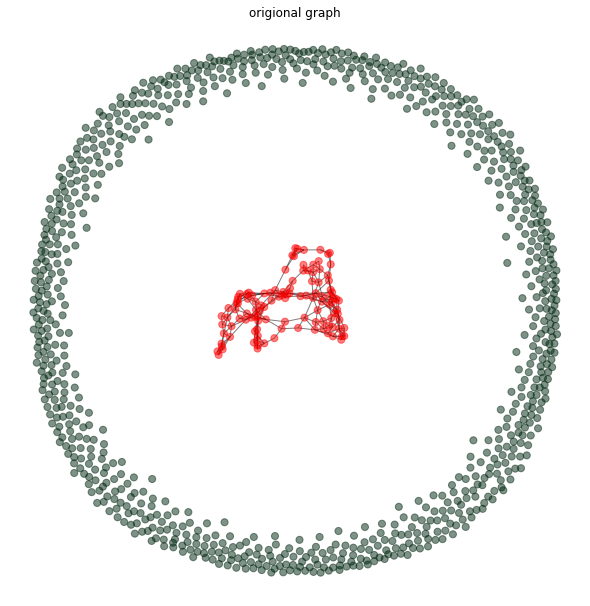

In [230]:
# first, let's see the origional graph

a = A[0].squeeze(0)
g = nx.from_numpy_matrix(a)

real_nodes = list(filter(g.degree, g.nodes))

pos = nx.spring_layout(g)

color_map = ['#00'+hex(10000)[2:]]*g.number_of_nodes()

for x in real_nodes: color_map[x] = 'r' 

plt.figure(figsize=(8, 8))
nx.draw(g, pos=pos, node_color=color_map,node_size=50, alpha=0.5)
plt.title('origional graph')
plt.show()

>The red nodes are real nodes, and the gray nodes on the outer cycle are added via to upsampling the node number to 1000.

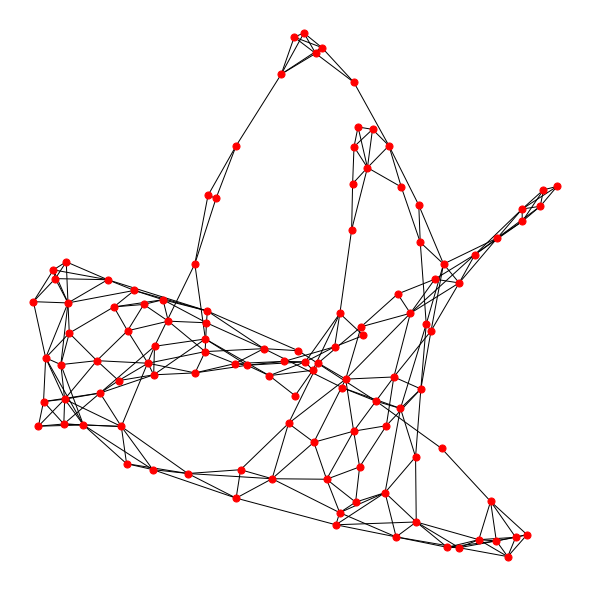

In [203]:
# the real nodes
sub_g = g.subgraph(real_nodes)
sub_pos = [pos.get(n) for n in sub_g.nodes]
real_nodes = list(filter(g.degree, g.nodes))
color_map = 'r'
plt.figure(figsize=(8, 8))
nx.draw(sub_g, pos=sub_pos, node_color=color_map, node_size=50)
plt.show()

> As it can be seen from the figure that, D&D data set decribes the structure of proteins.

## Pooling 1: 1000 nodes -> 100 nodes

In [204]:
# introduce the assignment matrix, let's see the result of soft clustering
def cluster(s):
    s = torch.from_numpy(s)
    s = s.squeeze(0)
    _, clst = torch.max(s, dim=1)
    clst = clst.numpy()
    return clst
s = S[0]
clst = cluster(s)
clst_num = max(clst)+1

color = np.random.rand(clst_num, 1)
color_dict = dict(zip(range(clst_num), color))

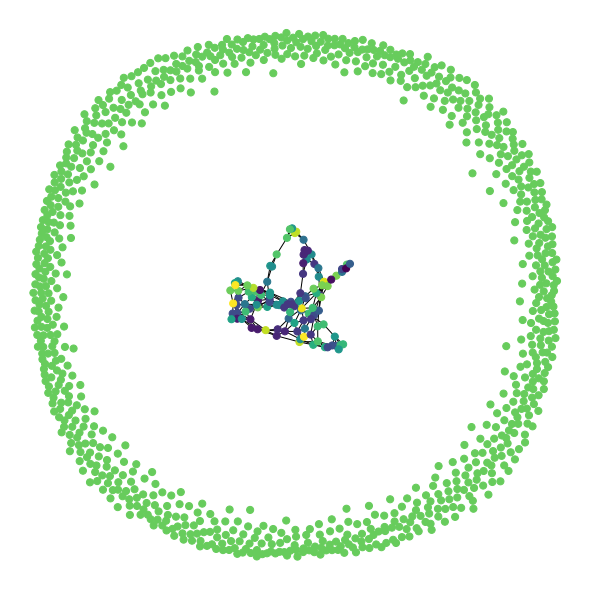

In [205]:
color_map = list(map(lambda x: color_dict[x], clst))

plt.figure(figsize=(8, 8))
nx.draw(g, pos=pos, cmap=plt.get_cmap('viridis'), node_color=color_map,node_size=50)
plt.show()

As indicated in our report, the assignment matrix is actually used for soft clustering. However, soft clustering is difficult to visualize. Here we show the clusters in a hard-clustering way. That is, each node is allocated to the cluster with the highest score. 

Because of the noises (the outer circle), the figure is not so clear, maybe we should focus on the real nodes.

In [206]:
# define some useful tools for plotting

def spawnPointsSquare(h, h_new, w, w_new, n, d=5):
    '''
    spawn n points randomly in a space [h:h_new, w:w_new]
    d is valid digit number
    '''
    x = np.random.randn(n, 1)*(h_new - h)+h
    y = np.random.randn(n, 1)*(w_new - w)+w
    p = [[round(*a, d), round(*b, d)] for a, b in zip(x, y)]
    return p

def spawnPointsCircle(center, r, n, d=5):
    '''
    spawn n points randomly in a circle 
    d is valid digit number
    '''
    if not n:
        return []
    rn = np.random.randn(n, 1) * r
    dn = np.random.randn(n, 1) * math.pi * 2
    x = [center[0] + a * math.cos(b) for a, b in zip(rn, dn)]
    y = [center[1] + a * math.sin(b) for a, b in zip(rn, dn)]
    p = [[round(*a, d), round(*b, d)] for a, b in zip(x, y)]
    return p

def spawnPointsCircleUni(r, n, d=5):
    '''
    spawn n points uniformly in a circle 
    d is valid digit number
    '''
    dn = [math.pi * 2 / n] * n
    dn = np.cumsum(dn)
    x = [r * math.cos(a) for a in dn]
    y = [r * math.sin(a) for a in dn]
    p = [[round(a, d), round(b, d)] for a, b in zip(x, y)]
    return p

def divideSpaceSquare(cnter, clst):
    '''
    divide space into subspaces
    input:
        :cnter (dict) number of nodes in each cluster
    return:
        :pos (dict{list[]}) coordinates of nodes in each cluster
    '''
    clst_num = len(cnter.keys())
    unit = min(cnter.values())
    unit_num = np.ceil(sum(cnter.values()) / unit) 
    unit_len = 1
    clst_len = list(map(lambda x: (x/unit)**(1/2) * unit_len, cnter.values()))
    clst_len = dict(zip(cnter.keys(), clst_len))
    h, w, h_new, w_new = 0, 0, 0, list(clst_len.values())[0]
    tmp = []
    for c in cnter.keys():
        if h_new < 1:
            h = h_new
            h_new += clst_len[c]
        else:
            w_new += clst_len[c]
            h = 0
            h_new = h + clst_len[c]
        p = spawnPoints(h, h_new, w, w_new, cnter[c])
        tmp.append(p)
        
    tmp = dict(zip(cnter.keys(), tmp))
    
    nodes = list(clst.keys())
    pos = {}
    for n in nodes:
        pos[n] = tmp[clst[n]].pop(0)
    return pos

def divideSpaceCircle(clst, l=100):
    '''
    illustrate the graph in a circle
    l: scale factor
    '''
    # spawn root nodes along a circle
    R = 1 * l
    r = 0.5 * l
    cnter = Counter(clst.values())
    clst_num = len(cnter.keys())
    nodes = list(clst.keys())
    centers = []
    centers.append([0, 0])
    small_circle = spawnPointsCircleUni(r, clst_num//3)
    centers.extend(small_circle)

    assert (clst_num - clst_num//3 - 1) > 0,r'cluster number must be larger than 1'
    
    big_circle = spawnPointsCircleUni(R, (clst_num - clst_num//3 - 1))
    centers.extend(big_circle)
    
    pos = {}
    center_idx = []
    for i, c in enumerate(cnter.keys()):
        p = []
        cls = list(filter(lambda x: c==clst[x], nodes))
        
        center = centers[i]
        center_idx.append(cls[0])
        pos[cls.pop(0)] = center
        p.extend(spawnPointsCircle(center, 1, len(cls))) # radius set to 1 here
        pos.update(zip(cls, p))

    return pos, center_idx

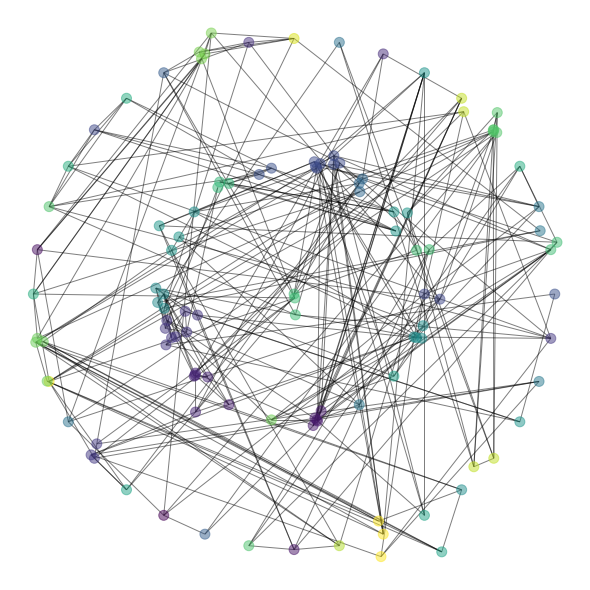

In [207]:
# let's see the clutering result of the real nodes
sub_g = g.subgraph(real_nodes)
real_clst = [clst[n] for n in real_nodes]
color_map = list(map(lambda x: color_dict[x], real_clst))
    
real_dict = dict(zip(sub_g.nodes, real_clst))
#pos_list = divideSpace(cnter, real_dict)
pos_list, center_idx = divideSpaceCircle(real_dict, 15)

# Now we focus on real_nodes
plt.figure(figsize=(8, 8))
nx.draw(sub_g, pos=pos_list, cmap=plt.get_cmap('viridis'), node_color=color_map,node_size=100, alpha=0.5)
plt.show()

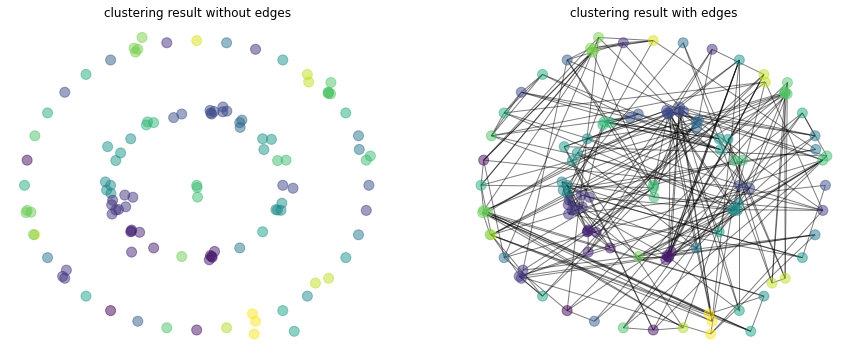

In [208]:
# remove the edges to see the clusters more clearly
tmp = nx.Graph()
tmp.add_nodes_from(real_nodes)

plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
nx.draw(tmp, pos=pos_list, cmap=plt.get_cmap('viridis'), node_color=color_map,node_size=100, alpha=0.5)
plt.title('clustering result without edges')

plt.subplot(1,2,2)
nx.draw(sub_g, pos=pos_list, cmap=plt.get_cmap('viridis'), node_color=color_map,node_size=100, alpha=0.5)
plt.title('clustering result with edges')

plt.show()

There are 55 clusters. 


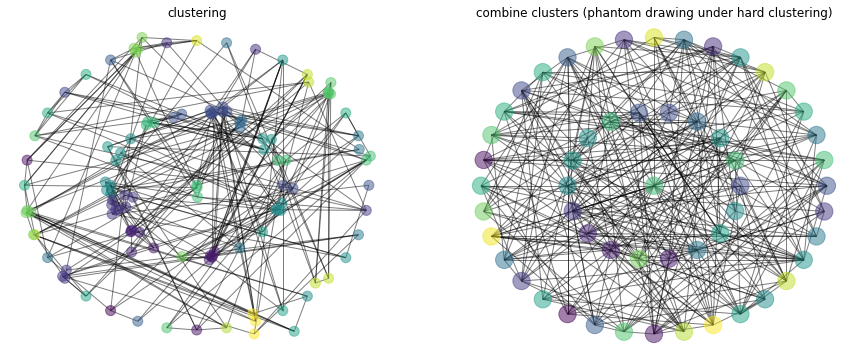

In [210]:
print('There are {} clusters. '.format(len(center_idx)))


# what about combining the nodes in each cluster? We would generate a phantom drawing.

fake_g = nx.Graph()
fake_g.add_nodes_from(center_idx)

pos = [pos_list.get(k) for k in center_idx]

color_map = list(map(lambda x: color_dict[x], real_clst))
color = [color_map[k] for k in center_idx]

pos = dict(zip(center_idx, pos))

# generate fake edges, just for better visulization
prob = 0.8
edge_list = []

# time complexity: O(nlog(n))
nodes = list(fake_g.nodes)
for i in range(len(nodes)):
    for j in range(i, len(nodes)):
        if np.random.rand() > prob:
            edge_list.append((nodes[i], nodes[j]))
fake_g.add_edges_from(edge_list)
    
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
nx.draw(sub_g, pos=pos_list, cmap=plt.get_cmap('viridis'), node_color=color_map,node_size=100, alpha=0.5)
plt.title('clustering')

plt.subplot(1,2,2)
nx.draw(fake_g, pos=pos, node_color=color, alpha=0.5)
plt.title('combine clusters (phantom drawing under hard clustering)')

plt.show()

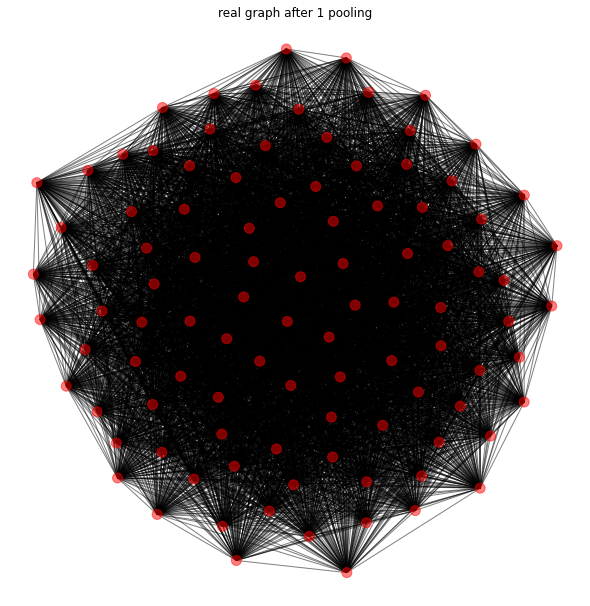

In [211]:
# the real graph after 1st pooling
a = A[1].squeeze(0)
g = nx.from_numpy_matrix(a)

real_nodes = list(filter(g.degree, g.nodes))
pos = nx.spring_layout(g)
color_map = ['k']*g.number_of_nodes()
for x in real_nodes: color_map[x] = 'r' 
plt.figure(figsize=(8, 8))
nx.draw(g, pos=pos, node_color=color_map,node_size=100, alpha=0.5)
plt.title('real graph after 1 pooling')
plt.show()

> Now there are 100 nodes.

## Pooling 2: 100 nodes -> 10 nodes

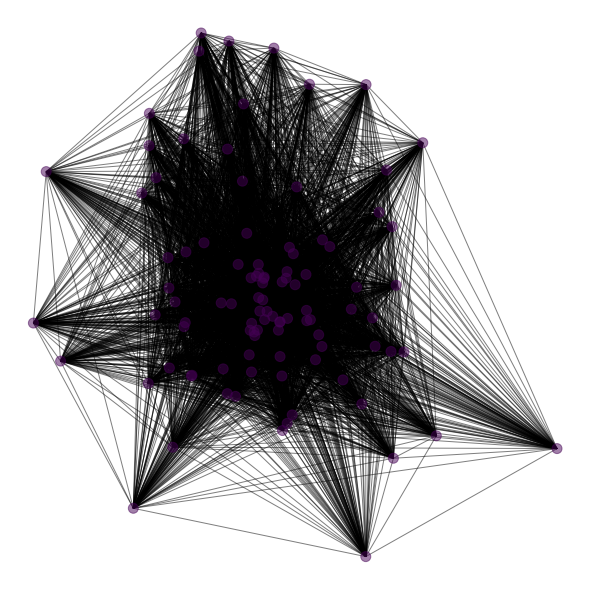

In [212]:
# via assignment matrix, show the clusters
s = S[1]
clst = cluster(s)
clst_num = max(clst)+1

color = np.random.rand(clst_num, 1)
color_dict = dict(zip(range(clst_num), color))

color_map = list(map(lambda x: color_dict[x], clst))
pos = spawnPointsCircle([0,0], 5, len(g.nodes))
pos = dict(zip(g.nodes, pos))

plt.figure(figsize=(8, 8))

nx.draw(g, pos=pos, cmap=plt.get_cmap('viridis'), node_color=color_map,node_size=100, alpha=0.5)
plt.show()

> **Why are all the nodes in purple?**

> As stated before, we used hard clustering to visualize the pooling process. Based on the second assignment matrix, if implementing hard clustering, each node would be allocated to **the same** cluster!

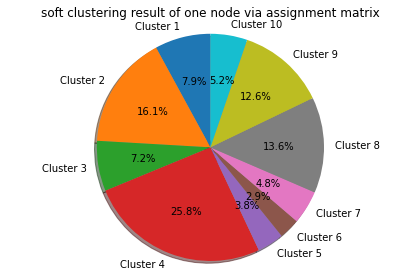

In [228]:
# let's see the assignment matrix in detail via pir chart
labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10']
prob = S[1].squeeze(0)[0,:]

fig1, ax1 = plt.subplots()
ax1.pie(prob, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')

plt.title('soft clustering result of one node via assignment matrix')
plt.tight_layout()
plt.show()

> Each node would be allocated to cluster 4, if using hard clustering. 

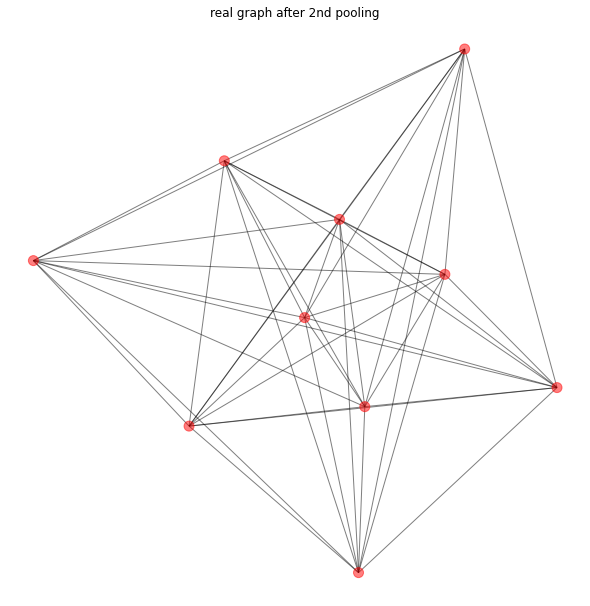

In [231]:
# the real graph after 2nd pooling

g = nx.from_numpy_matrix(A[2].squeeze(0))
real_nodes = list(filter(g.degree, g.nodes))
pos = nx.spring_layout(g)
color_map = ['k']*g.number_of_nodes()
for x in real_nodes: color_map[x] = 'r' 

plt.figure(figsize=(8, 8))
nx.draw(g, pos=pos, node_color=color_map,node_size=100, alpha=0.5)
plt.title('real graph after 2nd pooling')
plt.show()

## Pooling 3: 10 nodes -> 1 nodes 

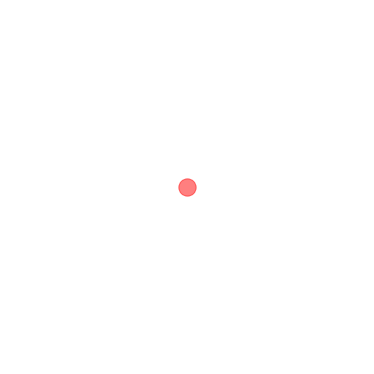

In [232]:
g = nx.Graph()
g.add_node(1)
pos = nx.spring_layout(g)
color_map = ['r']*g.number_of_nodes()

plt.figure(figsize=(5, 5))
nx.draw(g, pos=pos, node_color=color_map,node_size=300, alpha=0.5)
plt.show()

> After three poolings, there is only one node left in the graph. 